
 # Databases

## PETE 2061 Lab 11

<a id='top'></a>

## Load required python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import pandas as pd
import sqlite3

%matplotlib inline   
#In Jupyter notebook, this makes matplotlib.pyplot generate a plot even the first time plot() is called

In [2]:
# Load spreadsheet
xl = pd.ExcelFile('DCAwells_Solved/DCAwells_Solved/DCA_Well 2.xlsx')
# Print the sheet names
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('DCARegression')

['DCARegression', 'DCA Forecast']


In [ ]:
df1

## Lab 11 (Create your new .ipynb or .py file )
* Using the code given in this workbook (or the db_manipulation.py), write a Python code that loops through all given 17 wells. In each iteration of the loop:
    * Insert the Decline curve analysis model parameters into the DCAparams table in the database
    * Insert the actual and model rates and cumulative production into the Rates table in the database
    * Plot and save a figure of the rate and cumulative production vs time (in months).
<br>    
Hint: You need to use the exponential model if b = 0, and the hyperbolic model otherwise.

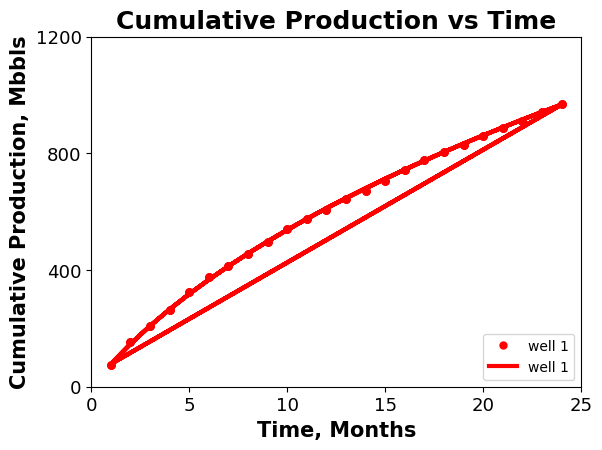

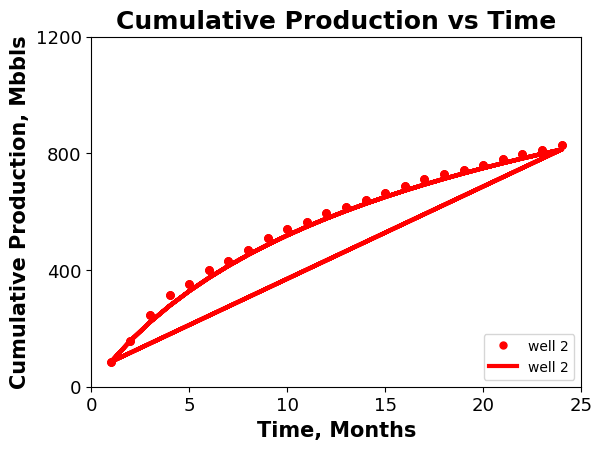

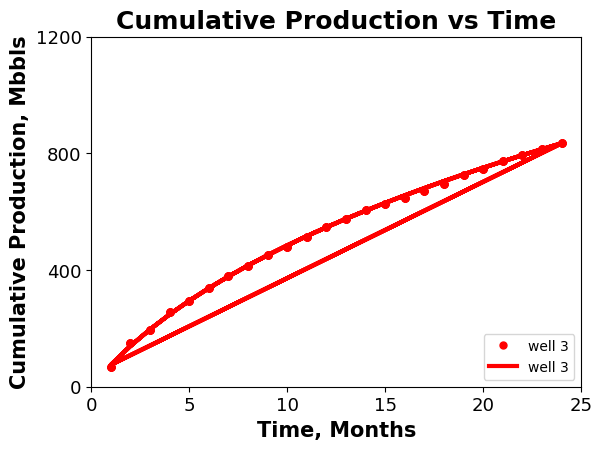

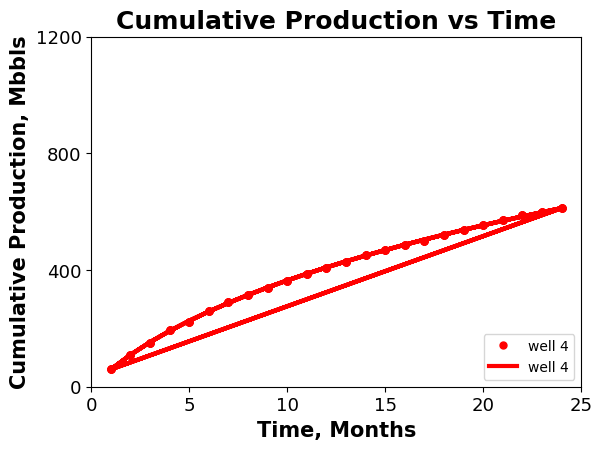

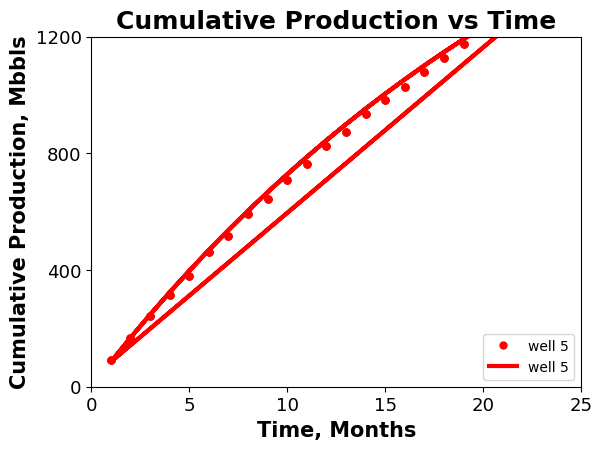

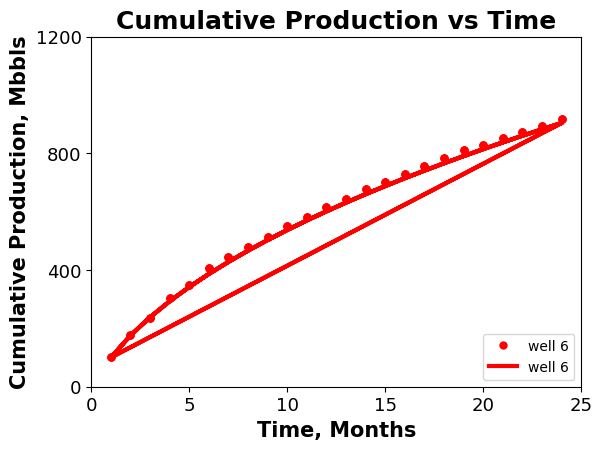

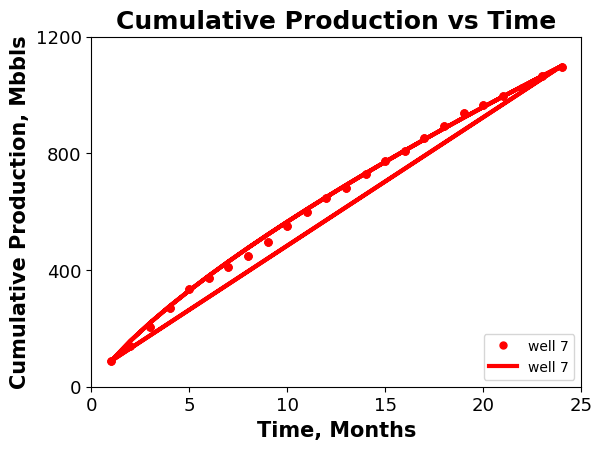

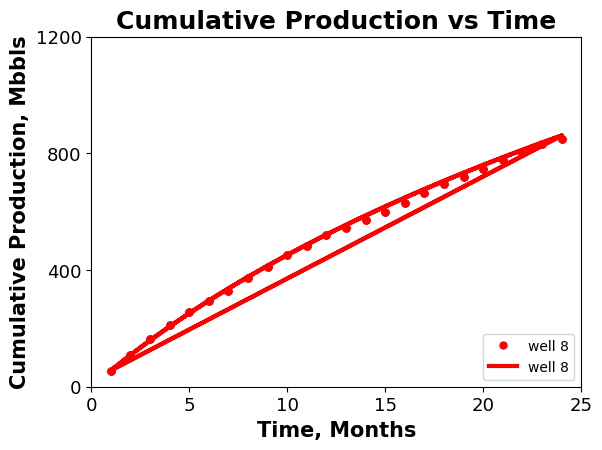

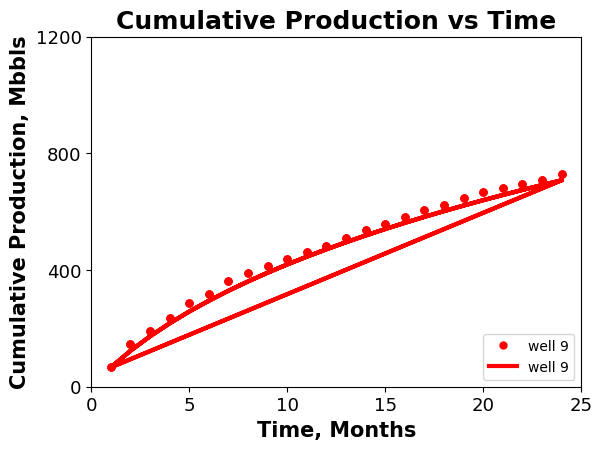

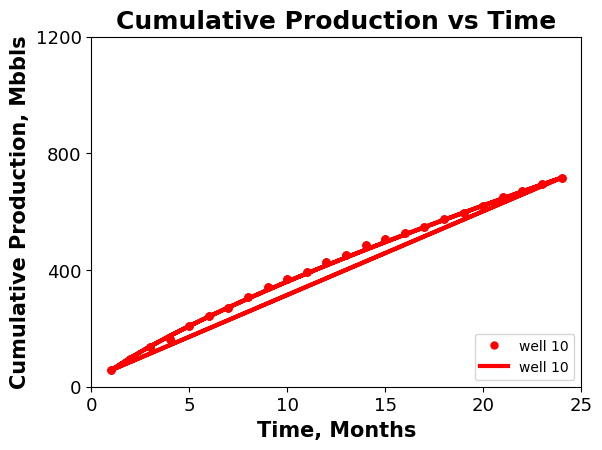

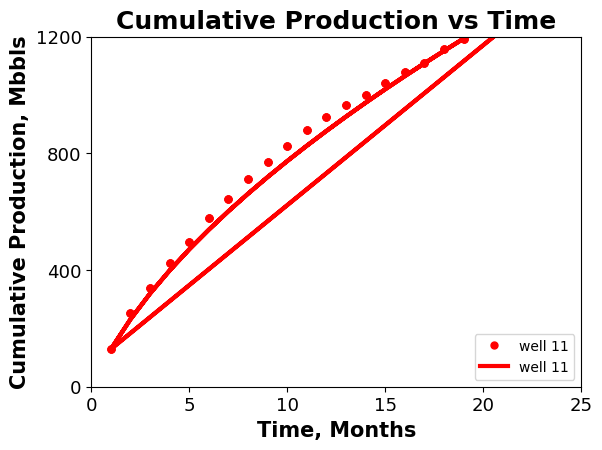

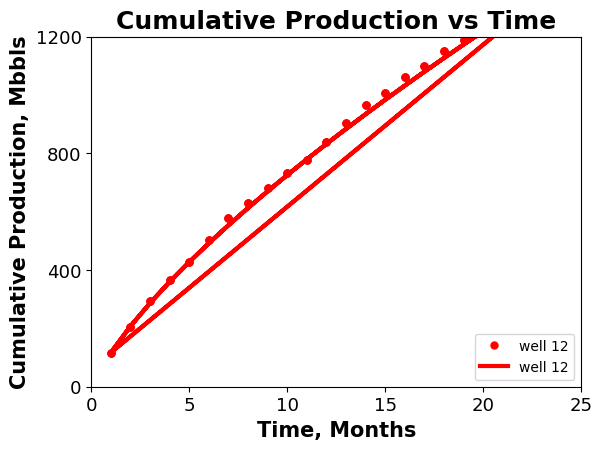

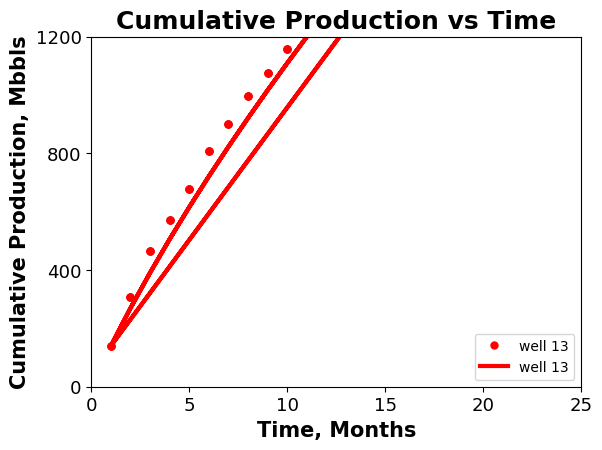

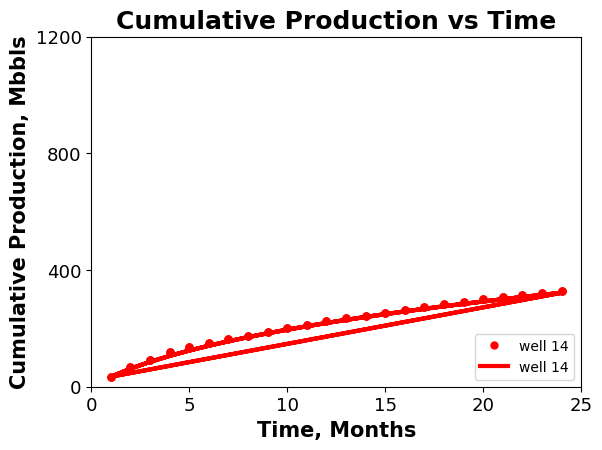

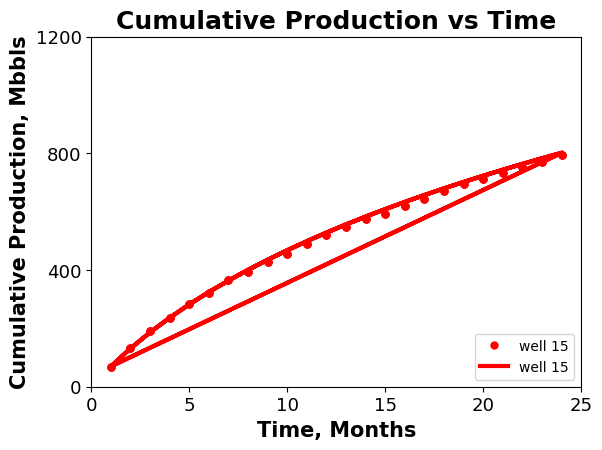

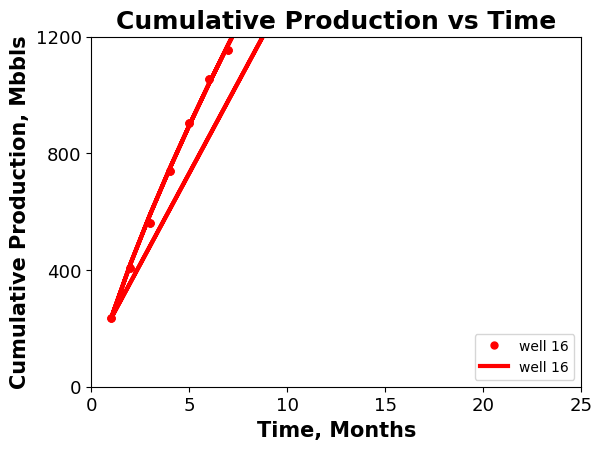

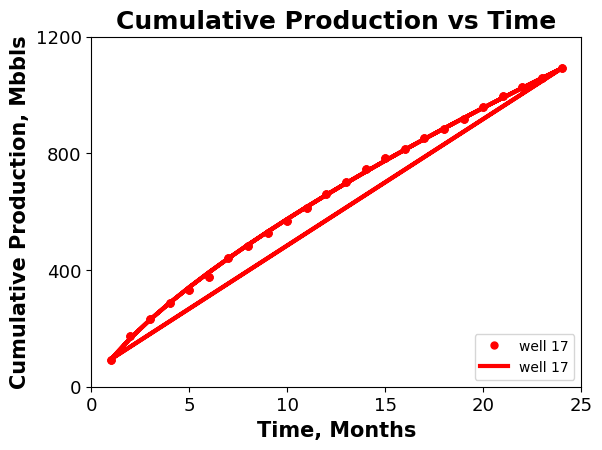

In [3]:
conn=sqlite3.connect("DCA.db")
cur=conn.cursor()
#remade a database names DCAparams1 because I originally put only 3 columns, when there should have been 4
#cur.execute("CREATE TABLE DCAparams1 (wellID INTEGER, qi REAL, Di REAL, b REAL)")
conn.commit()
dfLength=24
for i in range(1,18,1):
    wellID=i
    name=str(wellID)
    xl = pd.ExcelFile('DCAwells_Solved/DCAwells_Solved/DCA_Well {0}.xlsx'.format(name))
    df1 = xl.parse('DCARegression')
    conn = sqlite3.connect("DCA.db")
    cur = conn.cursor()
    rateDF = pd.DataFrame({'wellID':wellID*np.ones(dfLength,dtype=int), 'time':range(1,dfLength+1),'rate':df1.iloc[8:32,1].values})
    rateDF['Cum'] = rateDF['rate'].cumsum()
    qi = df1.iloc[2,3]
    Di=df1.iloc[3,3]
    b  = df1.iloc[4,3]
    cur.execute("INSERT INTO DCAparams1 VALUES ({},{},{},{})".format(wellID, qi, Di, b))
    conn.commit()
    t = np.arange(1,dfLength+1)
    Di = Di/12   
    if b==0:
        q=30.4375*qi*np.exp(-Di*t)
        Np=((30.4375*qi)-q)/Di
    else:
        q = 30.4375*qi/((1 + b*Di*t)**(1/b))
        Np = 30.4375*(qi/(Di*(1-b)))*(1-(1/(1+(b*Di*t))**((1-b)/b))) 
    error_q = rateDF['rate'].values - q
    SSE_q = np.dot(error_q, error_q)
    errorNp = rateDF['Cum'].values - Np
    SSE_Np = np.dot(errorNp,errorNp)
    
    rateDF['q_model'] = q
    rateDF['Cum_model'] = Np
    rateDF.to_sql("Rates", conn, if_exists="append", index = False)
    df1 = pd.read_sql_query("SELECT * FROM Rates;", conn)
    df2 = pd.read_sql_query("SELECT * FROM DCAparams1;", conn)
    
    conn.close()
    
    conn = sqlite3.connect("DCA.db")
    df1 = pd.read_sql_query("SELECT * FROM Rates WHERE wellID = {};".format(wellID), conn)

    titleFontSize = 18
    axisLabelFontSize = 15
    axisNumFontSize = 13

    currFig = plt.figure(figsize=(7,5), dpi=100)

    axes = currFig.add_axes([0.15, 0.15, 0.7, 0.7])

    axes.plot(df1['time'], df1['Cum']/1000, color="red", ls='None', marker='o', markersize=5,label = 'well '+str(wellID) )
    axes.plot(df1['time'], df1['Cum_model']/1000, color="red", lw=3, ls='-',label = 'well '+str(wellID) )
    axes.legend(loc=4)
    axes.set_title('Cumulative Production vs Time', fontsize=titleFontSize, fontweight='bold')
    axes.set_xlabel('Time, Months', fontsize=axisLabelFontSize, fontweight='bold') 
    axes.set_ylabel('Cumulative Production, Mbbls', fontsize=axisLabelFontSize, fontweight='bold')
    axes.set_ylim([0, 1200])
    axes.set_xlim([0, 25])
    xticks = range(0,30,5) 
    axes.set_xticks(xticks)
    axes.set_xticklabels(xticks, fontsize=axisNumFontSize); 

    yticks = [0, 400, 800, 1200]
    axes.set_yticks(yticks)
    axes.set_yticklabels(yticks, fontsize=axisNumFontSize); 

    currFig.savefig('well'+str(wellID)+'_Gp.png', dpi=600)